# Coding it Forward: Machine Learning & The Wisdom of the Crowds

<img src="./images/CIF_wordmark.png">

By the end of this notebook, you'll be able to fit ensemble models of both the bagging and boosting variety. 

This notebook is organized into four main sections:
1. Read in the data and data prep.
2. Fit and visualize a single decision tree with `scikit-learn`.
3. Motivation behind ensemble modeling.
4. Fit ensemble models with `scikit-learn`.
    - Fit bagging models.
    - Fit boosting models.

In [1]:
# First, we'll read in all of our libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


# Set a random seed to ensure reproducibility. These
# algorithms involve randomness, so setting a seed is
# helpful for us to ensure we get similar results!
np.random.seed(42)

### Part 1: Read in the data and data prep.

The dataset used here examines 462 individuals (all male) from South Africa, whether or not they were diagnosed with coronary heart disease (CHD), and a number of covariates. This dataset was shared via a 1983 South African Medical Journal article published by Rousseauw _et al_. and was downloaded from [the _Elements of Statistical Learning_ dataset page](https://web.stanford.edu/~hastie/ElemStatLearn/data.html) hosted by Trevor Hastie. (Adapted from [this page](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.info.txt).)

In [2]:
# Read our data into Pandas.
data = pd.read_csv('./SAheart.csv')

In [3]:
# Examine first five rows of data.
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


Adapted from [this page](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.info.txt).
- `sbp`: systolic blood pressure
- `tobacco`: cumulative tobacco (kg)
- `ldl`: low density lipoprotein cholesterol
- `adiposity`: _no description given_
- `famhist`: family history of heart disease (Present, Absent)
- `typea`: type-A behavior
- `obesity`: _no description given_
- `alcohol`: current alcohol consumption
- `age`: age at onset
- `chd`: response variable, 1 = coronary heart disease, 0 = no CHD.

In order to fit our models, we'll need to convert the `famhist` variable to numeric. I'll convert values of `Present` to 1 and `Absent` to 0.

In [4]:
# Map 'Present' to 1 and 'Absent' to 0 and
# overwrite the original 'famhist' column.
data['famhist'].replace({'Present': 1,
                         'Absent': 0},
                        inplace=True)

In [5]:
# Confirming we converted to 1s and 0s.
data['famhist']

0      1
1      0
2      1
3      1
4      1
      ..
457    0
458    0
459    0
460    0
461    1
Name: famhist, Length: 462, dtype: int64

In [6]:
# Define our X (inputs) and y (output) variables.
X = data.drop('chd', axis=1, inplace=False)
y = data['chd']

In [7]:
# Split our data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

### Part 2: Fit and visualize a single decision tree with `scikit-learn`.

In [8]:
# In this example, I select a max_depth of 2. This 
# means that our tree will only grow to include 2
# levels below the initial "root" node.

# Since I want to visualize our output below, a
# max_depth of 2 is a convenient decision. However,
# you can play around with many different values!

single_tree = DecisionTreeClassifier(max_depth=2,
                                     random_state=42)

In [9]:
# Fit one single decision tree (CART) to our.
# training data.
single_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

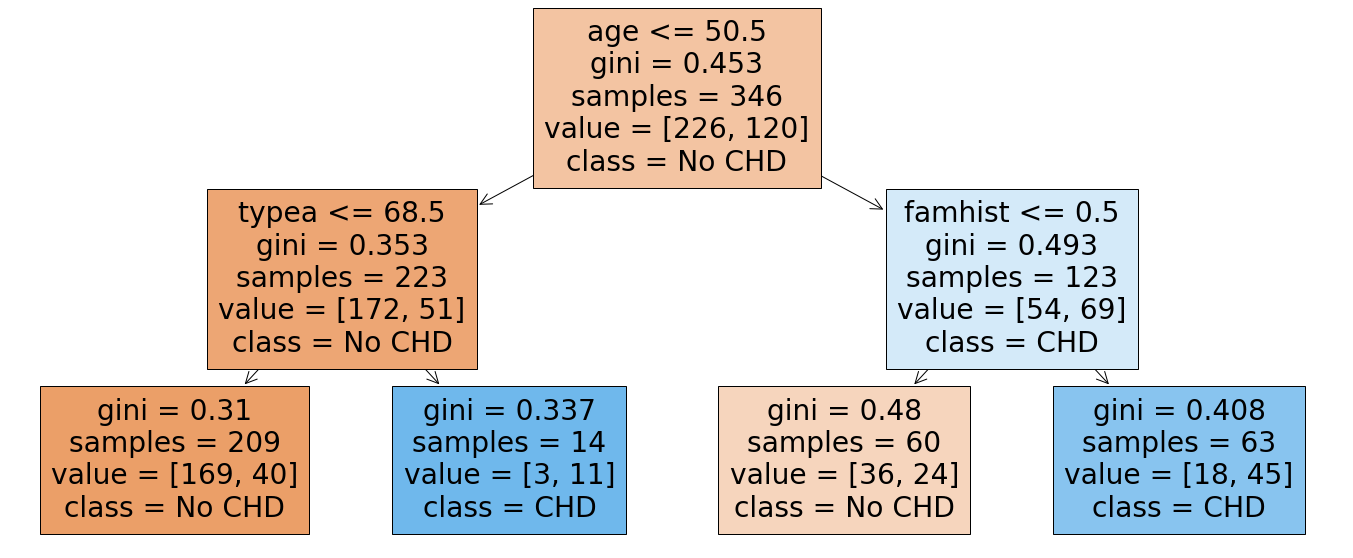

In [10]:
# Resize plot.
plt.figure(figsize = (24,10))

# Plot visual representation of our decision tree.
plot_tree(single_tree,
          feature_names = X_train.columns,
          class_names = ['No CHD', 'CHD'],
          filled = True);

In [11]:
# Generate model predictions from our training and testing data.
y_train_preds = single_tree.predict(X_train)
y_test_preds = single_tree.predict(X_test)

In [12]:
# Evaluate our model's performance using the 
# area under the ROC curve, or ROC AUC score.

# Scores closer to 100% are better. 
# Scores at 50% or below are very bad.

print(f'ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

ROC AUC score on training data is: 0.6868731563421829
ROC AUC score on testing data is: 0.6394736842105264


We note that our model achieves nearly 69% ROC AUC on the training data, but only about 64% on the testing data. 
- Since the model was built on the training data, the model has already seen "the answers." Thus, seeing 69% ROC AUC on the training data is probably an overestimate of how our model would perform on "never-before-seen" data... since our model had already seen that data during training!
- Since the testing data was "held out," we expect that the 64% ROC AUC is a better estimate of how our model would perform on "never-before-seen" data. 

_(Aside: There are a lot of caveats to this! If all of the data you're using for modeling -- whether it's training or testing -- falls prey to some sort of sampling biases, like self-selection bias or survivorship bias or something else, then there's a good chance that your testing ROC AUC [or any metric] is still going to be an overconfident estimate in your model's performance!)_

**Our model seems to perform OK here... can we do better?**

### Part 2: Motivation behind ensemble modeling.

Any one person can make a decision, but that person is susceptible to their own biases and perspectives.

#### Wisdom of the Crowds
<img src="./images/penelope.jpeg">

[Inspired by this NPR story](https://www.npr.org/sections/money/2015/08/07/429720443/17-205-people-guessed-the-weight-of-a-cow-heres-how-they-did).

1. Gather a group of people. 
2. Get them each to independently guess Penelope's weight in pounds. (Penelope is the cow in the above image.)
    - Someone "wins" if their individual guess is closer to the correct answer than the average of all guesses.
3. See how many people outperform the average guess!

In [13]:
# Put the players' guesses in this list.
list_of_guesses = [100, 5000]

# Calculate the average guess.
average_guess = np.mean(list_of_guesses)

# Create a count of winners, starting at 0.
winner_count = 0

# Iterate through each of the guesses.
for guess in list_of_guesses:
    
    # If a guess is closer to the true weight (1355 pounds)
    # than the average guess:
    if abs(guess - 1355) < abs(average_guess - 1355):
        
        # Add one to our "winner count" and print out that 
        # we have a winner.
        winner_count += 1
        print("We have a winner!")

print(f'The average guess is {average_guess}.')

print(f'The number of people who were closer to the truth \
than the average is {winner_count}.')

print(f'That is roughly {np.round(winner_count/len(list_of_guesses),0)}% \
of guesses!')

The average guess is 2550.0.
The number of people who were closer to the truth than the average is 0.
That is roughly 0.0% of guesses!


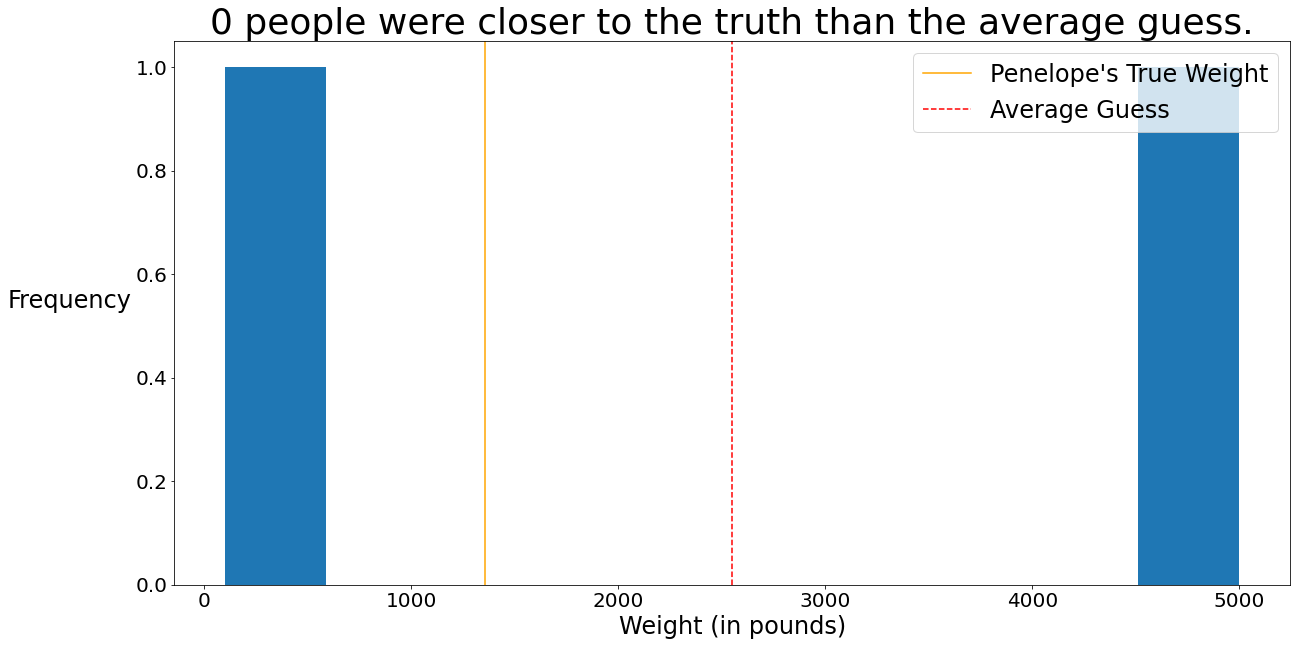

In [14]:
plt.figure(figsize = (20,10))

plt.title(f'{winner_count} people were closer to the truth \
than the average guess.',
          fontsize=36)

plt.hist(list_of_guesses)

plt.axvline(1355,
            color='orange',
            label='Penelope\'s True Weight')

plt.axvline(average_guess,
            color='red',
            linestyle='--',
            label='Average Guess')

plt.xlabel('Weight (in pounds)',
           fontsize=24)
plt.ylabel('Frequency',
           rotation=0,
           ha='right',
           fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=24);

Generally, a group of individuals will come up with a better guess than one individual on their own. In some cases, an individual may outperform a group of people -- but it is almost always a better bet to go with a group decision than an individual one.

##### We call this the wisdom of the crowds. 

In this way, a model is not terribly different from a person! Individual models, like individual people, will have their own limitations. A model may be too simple for a problem at hand, or too complex. A model may systematically underestimate a quantity of interest, or systematically overestimate it. An individual decision tree will almost surely suffer from some areas where it does not generate good predictions.

However, by creating many different models and combining their predictions together in a principled way, we can often improve our overall predictive performance!

Just like diverse human perspectives is often correlated with organizations making better decisions and improved business performance, we can apply the same judgment to models.

### Part 4A: Fit ensemble _bagging_ models with `scikit-learn`.

Among bagging models, we will fit:
1. A set of bagged _(bootstrap aggregated)_ decision trees.
2. A random forest.
3. A set of extremely randomized trees.

#### Bagging Classifier

In [15]:
# Instantiate bagging classifier model.
bag = BaggingClassifier(n_estimators=1_000,
                        random_state=42)

# Fit bagging classifier model to training data.
bag.fit(X_train, y_train)

# Generate bagging classifier predictions from training and testing sets.
y_train_preds = bag.predict(X_train)
y_test_preds = bag.predict(X_test)

# Evaluate bagging classifier predictions from training and testing sets.
print(f'Bagging classifier model ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'Bagging classifier model ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

Bagging classifier model ROC AUC score on training data is: 1.0
Bagging classifier model ROC AUC score on testing data is: 0.5802631578947368


#### Random Forest (RF) Classifier

In [16]:
# Instantiate random forest model.
rf = RandomForestClassifier(n_estimators=1_000,
                            random_state=42)

# Fit random forest model to training data.
rf.fit(X_train, y_train)

# Generate RF predictions from training and testing sets.
y_train_preds = rf.predict(X_train)
y_test_preds = rf.predict(X_test)

# Evaluate RF predictions from training and testing sets.
print(f'Random forest model ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'Random forest model ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

Random forest model ROC AUC score on training data is: 1.0
Random forest model ROC AUC score on testing data is: 0.6309210526315789


#### Extremely Randomized Trees (ERT) Classifier

In [17]:
# Instantiate Extremely Randomized Trees Classifier.
ert = ExtraTreesClassifier(n_estimators=1_000,
                           random_state=42)

# Fit ERT model to training data.
ert.fit(X_train, y_train)

# Generate ERT predictions from training and testing sets.
y_train_preds = ert.predict(X_train)
y_test_preds = ert.predict(X_test)

# Evaluate ERT predictions from training and testing sets.
print(f'Extremely Randomized Trees model ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'Extremely Randomized Trees model ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

Extremely Randomized Trees model ROC AUC score on training data is: 1.0
Extremely Randomized Trees model ROC AUC score on testing data is: 0.6263157894736842


### Part 4B: Fit ensemble _boosting_ models with `scikit-learn`.

Among boosting models, we will fit:
1. An AdaBoost model.
2. A Gradient Boosted model.

#### AdaBoost Classifier (ABC)

In [18]:
# Instantiate AdaBoost Classifier.
abc = AdaBoostClassifier(n_estimators=1_000,
                         random_state=42)

# Fit ABC model to training data.
abc.fit(X_train, y_train)

# Generate ABC predictions from training and testing sets.
y_train_preds = abc.predict(X_train)
y_test_preds = abc.predict(X_test)

# Evaluate ABC predictions from training and testing sets.
print(f'AdaBoost model ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'AdaBoost model ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

AdaBoost model ROC AUC score on training data is: 1.0
AdaBoost model ROC AUC score on testing data is: 0.6


#### Gradient Boosting Classifier (GBC)

In [19]:
# Instantiate Gradient Boosting Classifier.
gbc = GradientBoostingClassifier(n_estimators=1_000,
                                 random_state=42)

# Fit GBC model to training data.
gbc.fit(X_train, y_train)

# Generate GBC predictions from training and testing sets.
y_train_preds = gbc.predict(X_train)
y_test_preds = gbc.predict(X_test)

# Evaluate GBC predictions from training and testing sets.
print(f'Gradient Boosting model ROC AUC score on training data is: {roc_auc_score(y_train, y_train_preds)}')
print(f'Gradient Boosting model ROC AUC score on testing data is: {roc_auc_score(y_test, y_test_preds)}')

Gradient Boosting model ROC AUC score on training data is: 1.0
Gradient Boosting model ROC AUC score on testing data is: 0.5677631578947369


### Takeaways
The most sophisticated model is not guaranteed to be the one with best performance! In this case, one simple decision tree bound at a `max_depth` of 2 has better testing performance than all of the more sophisticated models we ran here.

When doing machine learning, there are a lot of **hyperparameters**, or quantities that you must select when building models that cannot be learned from the data. For example, we used 1,000 estimators (e.g. individual decision trees) in each of the ensemble models. _That may not be a good decision!_ 
- Maybe we want more estimators to improve model performance.
- Maybe we want fewer estimators to speed up our model fitting and prediction process.

Machine learning models have many, many hyperparameters. 
- Tree-based models have many defaults, but [you can see lots of the hyperparameters here](https://scikit-learn.org/stable/modules/ensemble.html).
- If you're using a $k$-nearest neighbors model, you need to select the value of $k$ (the number of neighbors to take into account when building the model).
- If you're using a linear or logistic regression model, you need to select the value of $\lambda$ (or $\alpha$ or $C$) that controls how strongly you want to regularize your model during the model fitting process.

To sum up:
- Fancier or more complex is not necessarily better.
- Be sure to explore your hyperparameters! Follow [best practices](https://scikit-learn.org/stable/modules/grid_search.html) when doing so, and it's always, **_always_** a good idea to know what each hyperparameter is doing.